In [1]:
import numpy as np
import pandas as pd

### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 940
days = 15

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,i+10,i+11,i+12,i+13,i+14,Close
0,249.86,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759
1,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267
2,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021
3,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,236.775
4,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498,241.759,239.267,238.021,236.775,241.759


### Calculate squared daily deviation 

In [5]:
#Calculate squared daily deviation
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
dv = np.sqrt((dv ** 2).mean())
dv

dv    5.360912
dtype: float64

### Split train/test set

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Create cross validation folds

In [7]:
def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 

### Define metrics and print metrics

In [8]:
# Import metrics, Crete custom metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    print('RMSE %f'%  rmse(test, pred))
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')

In [9]:
n_splits = 3
size =305

cv_sets = create_cv_sets(n_splits, size)

### Benchmark model 

In [10]:
def model_persistence(x):
    return x

def set_prediction(test_X):
    predictions = list()
    for x in test_X['i+%s' % str(days-1)]:
        yhat = model_persistence(x)
        predictions.append(yhat)
    return predictions

#Iterate through cv_sets, calc errors, print metrics
benchmark_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    pred = set_prediction(X_test)
    benchmark_errs.append(rmse(y_test['Close'], pred))
    print_metrics(y_test['Close'], pred)

RMSE 4.946223
Root Mean Squared Percentage Error 1.683514
Mean Absolute Error: 3.861048
Explained Variance Score: 0.833646
Mean Squared Error: 24.465118
R2 score: 0.832822

RMSE 4.966771
Root Mean Squared Percentage Error 1.690389
Mean Absolute Error: 3.901902
Explained Variance Score: 0.828114
Mean Squared Error: 24.668811
R2 score: 0.827621

RMSE 4.969332
Root Mean Squared Percentage Error 1.691252
Mean Absolute Error: 3.922328
Explained Variance Score: 0.823976
Mean Squared Error: 24.694263
R2 score: 0.823391



### Train and Tune Linear Regressor

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

def get_lr_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Iterate through cross validation sets, calc errors, print metrics

In [12]:
#Iterate through cv_sets, calc errors, print metrics
lr_regs = []
lr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    lr_reg = get_lr_model(X_train, y_train)
    lr_regs.append(lr_reg)
    pred = lr_reg.predict(X_test)
    lr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)

RMSE 5.214517
Root Mean Squared Percentage Error 1.774942
Mean Absolute Error: 4.150993
Explained Variance Score: 0.814901
Mean Squared Error: 27.191192
R2 score: 0.814194

RMSE 5.240401
Root Mean Squared Percentage Error 1.783593
Mean Absolute Error: 4.190599
Explained Variance Score: 0.808458
Mean Squared Error: 27.461797
R2 score: 0.808104

RMSE 5.224373
Root Mean Squared Percentage Error 1.777977
Mean Absolute Error: 4.197222
Explained Variance Score: 0.805349
Mean Squared Error: 27.294074
R2 score: 0.804797



In [13]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

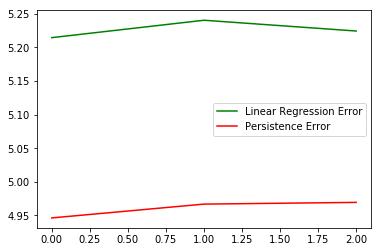

In [14]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')

plt.legend()
plt.show()

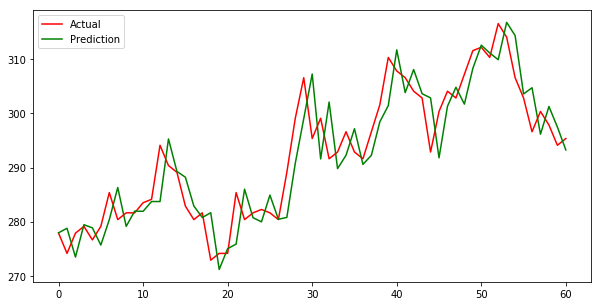

In [15]:
rcParams['figure.figsize'] = 10,5
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, lr_regs[n_splits - 1].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [16]:
lr_regs[0].coef_

array([[ 0.03137054, -0.02382885,  0.08605753, -0.18382767,  0.17095906,
        -0.10518591,  0.05611863,  0.05459128, -0.0893329 ,  0.04567823,
        -0.10216331,  0.15309937,  0.00304086, -0.24233225,  1.14615849]])

In [17]:
from sklearn.linear_model import Ridge 

def get_ridge_model(X_train, X_test, y_train, y_test):
    r_reg = Ridge()
    r_reg.fit(X_train, y_train)
    return r_reg

In [18]:
#Iterate through cv_sets, calc errors, print metrics
rr_regs=[]
rr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    rr_reg = get_ridge_model(X_train,X_test,y_train,y_test)
    pred = rr_reg.predict(X_test)
    rr_regs.append(rr_reg)
    rr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)    

RMSE 5.207648
Root Mean Squared Percentage Error 1.770461
Mean Absolute Error: 4.117220
Explained Variance Score: 0.817914
Mean Squared Error: 27.119600
R2 score: 0.814683

RMSE 5.226986
Root Mean Squared Percentage Error 1.776740
Mean Absolute Error: 4.152375
Explained Variance Score: 0.811678
Mean Squared Error: 27.321385
R2 score: 0.809086

RMSE 5.214525
Root Mean Squared Percentage Error 1.772260
Mean Absolute Error: 4.165246
Explained Variance Score: 0.808840
Mean Squared Error: 27.191267
R2 score: 0.805532



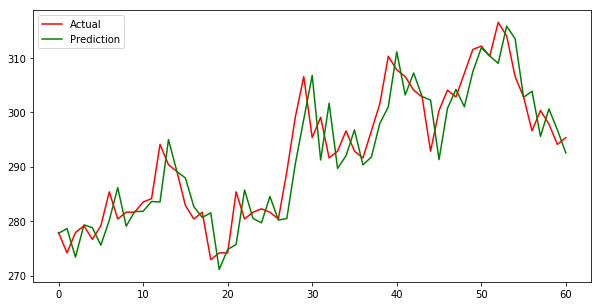

In [19]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, rr_regs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [20]:
rr_regs[1].coef_

array([[ 0.01968979, -0.02920177,  0.09869292, -0.19045368,  0.17096237,
        -0.10454164,  0.05716121,  0.0547676 , -0.09234202,  0.05215147,
        -0.10665193,  0.14403303,  0.01436928, -0.24843981,  1.13456133]])

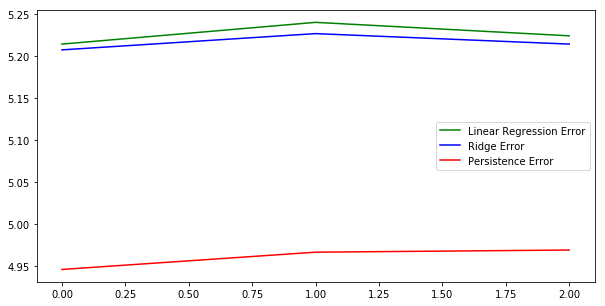

In [21]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [22]:
from sklearn.svm import LinearSVR
def lsvr(X_train, X_test, y_train, y_test):
    svr = LinearSVR()
    svr.fit(X_train, y_train.values.ravel())
    return svr

In [23]:
#Iterate through cv_sets, calc errors, print metrics
svrs=[]
svr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svr = lsvr(X_train, X_test, y_train, y_test)
    svrs.append(svr)
    pred = svr.predict(X_test)
    svr_errs.append(rmse(y_test.values.ravel(), pred)) 
    print_metrics(y_test.values.ravel(), pred)


RMSE 7.631655
Root Mean Squared Percentage Error 2.628765
Mean Absolute Error: 6.401137
Explained Variance Score: 0.826517
Mean Squared Error: 58.242162
R2 score: 0.602013

RMSE 5.893809
Root Mean Squared Percentage Error 1.995593
Mean Absolute Error: 4.698227
Explained Variance Score: 0.823010
Mean Squared Error: 34.736982
R2 score: 0.757267

RMSE 5.022935
Root Mean Squared Percentage Error 1.710001
Mean Absolute Error: 4.007257
Explained Variance Score: 0.819757
Mean Squared Error: 25.229871
R2 score: 0.819560



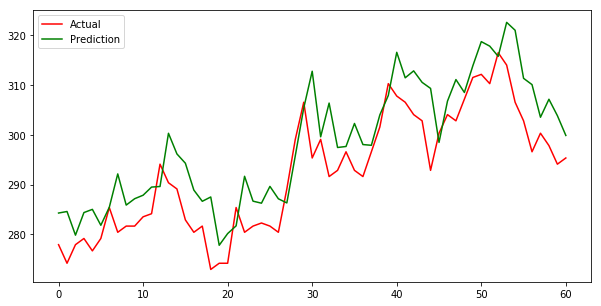

In [24]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

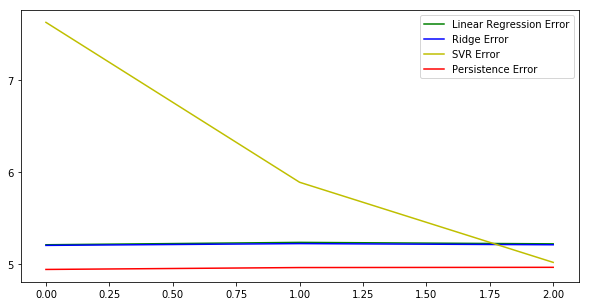

In [25]:
rcParams['figure.figsize'] = 10,5
dvl = [dv]* n_splits
t = range(n_splits)
plt.yticks(np.arange(0, max(svr_errs)))
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, svr_errs, 'y', label='SVR Error')
plt.plot(t, benchmark_errs, 'r', label='Persistence Error')
plt.legend()
plt.show()

In [26]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00,301.20, 309.20,307.00,310.20,307.40]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred


array([[309.27066096]])

In [27]:
from sklearn.externals import joblib
joblib.dump(lr_regs[0], 'prediction_model_full.pkl') 

['prediction_model_full.pkl']